In [1]:
import numpy as np
import os
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


sf = pd.read_feather('sample_soundly_from_here.df').set_index('index')
df = pd.read_feather('../cleaned_images.df')
train = df[df.ds_type == 'train']
seqs = pd.read_feather('../cleaned_seqs.df').set_index('index')
n = (len(seqs[(seqs.view_direction != "Sideways") & (seqs.ds_type == 'train')]))
train.value_counts("view_direction")

view_direction
Forward     87228
Sideways    40838
Backward      623
dtype: int64

In [2]:
sf["ind"] = sf.index.values
col = sf.groupby(['City',"seq_key"])['keys'].apply(lambda x: np.array([len(np.unique(np.concatenate(x.values))),len(x)])).to_frame()

col['n_img'] = [i[0] for i in col['keys']]
col['n_seqs'] = [i[1] for i in col['keys']]
col.drop(columns=['keys'],inplace=True)
col = col.join(sf.groupby(['City',"seq_key"])['ind'].unique())
col.head()

n_img  n_seqs  \
City  seq_key                                 
amman 004Lc-M_TjGRo7Ve-0Fhqw     89      37   
      0EKKUvzcWMy7qAb_6sGp4w     15       6   
      0cohlj9r0ib7jqpp9yljwb    133      56   
      3aaMS6L7SvK1riHOHQMq9Q     25      11   
      4iomgr2l1hy6syonnkyu3q      5       1   

                                                                            ind  
City  seq_key                                                                    
amman 004Lc-M_TjGRo7Ve-0Fhqw  [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 1...  
      0EKKUvzcWMy7qAb_6sGp4w         [14326, 14327, 14328, 14329, 14330, 14331]  
      0cohlj9r0ib7jqpp9yljwb  [16428, 16429, 16430, 16431, 16432, 16433, 164...  
      3aaMS6L7SvK1riHOHQMq9Q  [54264, 54265, 54266, 54267, 54268, 54269, 542...  
      4iomgr2l1hy6syonnkyu3q                                            [69526]

In [3]:
col = col.sample(frac=1,random_state = 1)
col["rc"] = [col.iloc[: i+1, 1].sum() for i in range(len(col))]
s= (col['rc'] > n).argmax()
print(col.iloc[:s,0].sum())

41032


In [4]:
inds = np.concatenate(col.iloc[:s,2].values)
chosen = sf.loc[inds]

Synthesize data sets

In [5]:
seqs[(seqs.view_direction == "Sideways") | (seqs.ds_type != 'train')].value_counts(["ds_type","view_direction"])

ds_type  view_direction
train    Sideways          18100
val      Sideways           2266
test     Forward            2234
val      Forward            2176
test     Sideways           2078
val      Backward             59
test     Backward              1
dtype: int64

In [6]:
chosen.value_counts("view_direction")

view_direction
Forward     17897
Backward      261
dtype: int64

In [7]:
chosen['ds_type'] = 'train'

def flip_50_percent(df):

    flip = df.loc[df.view_direction == "Sideways"].sample(frac=0.5,random_state=0).index

    df.loc[flip,"keys"] = df.loc[flip,"keys"].apply(lambda x: x[::-1])
    df.loc[flip,"Paths"] = df.loc[flip,"Paths"].apply(lambda x: x[::-1])
    df.loc[flip,"Flip"] = True

    flip = df.loc[df.view_direction != "Sideways"].sample(frac=0.5,random_state=0).index
    df.loc[flip,"keys"] = df.loc[flip,"keys"].apply(lambda x: x[::-1])
    df.loc[flip,"Paths"] = df.loc[flip,"Paths"].apply(lambda x: x[::-1])
    df.loc[flip,"Flip"] = True

    df.loc[df.Flip.isna(),"Flip"] = False

    return df

chosen = flip_50_percent(chosen)

seqs = pd.concat([seqs[(seqs.view_direction == "Sideways") | (seqs.ds_type != 'train')], chosen])

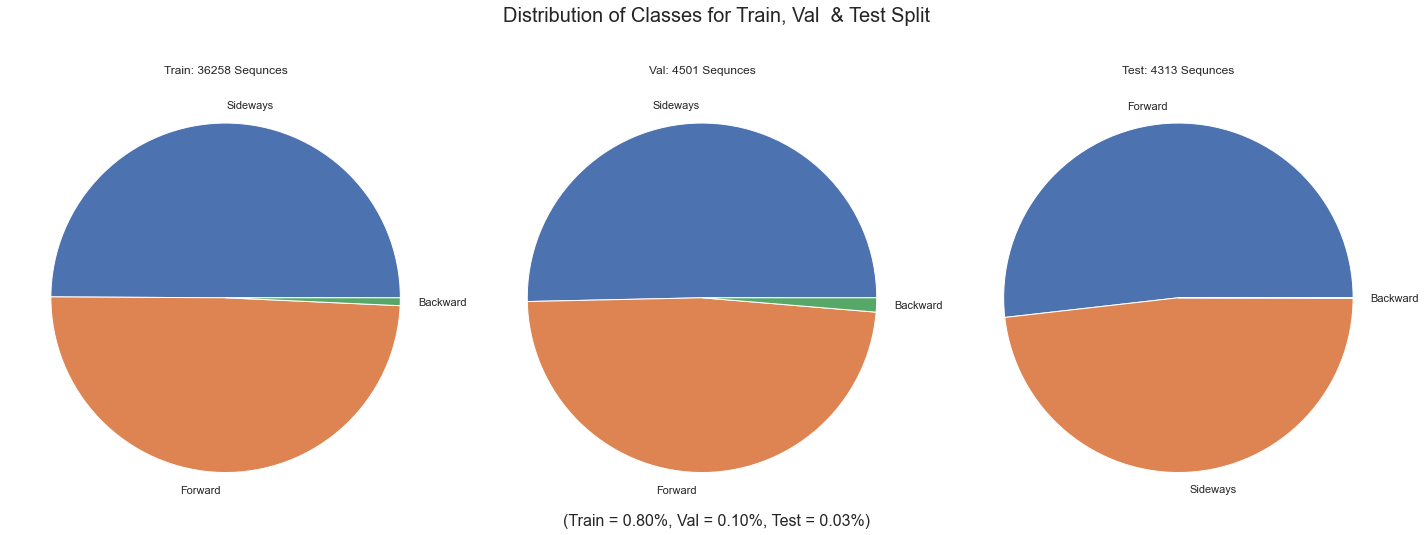

In [8]:
sns.set_theme()
train_df = seqs.loc[seqs["ds_type"]=="train"]
val_df = seqs.loc[seqs["ds_type"]=="val"]
test_df = seqs.loc[seqs["ds_type"]=="test"]
def plot_pie(df,ax):

    x = df["view_direction"].value_counts()

    ax.pie(x.values,labels = x.index )

fig,ax = plt.subplots(1,3,figsize=[20,8])

ax[0].title.set_text(f'Train: {len(train_df)} Sequnces')
ax[1].title.set_text(f'Val: {len(val_df)} Sequnces')
ax[2].title.set_text(f'Test: {len(test_df)} Sequnces')


plot_pie(train_df,ax[0])
plot_pie(val_df,ax[1])
plot_pie(test_df,ax[2])
plt.suptitle(f"Distribution of Classes for Train, Val  & Test Split",fontsize=20)
plt.tight_layout()
plt.figtext(0.5, 0.08, f"(Train = {len(train_df)/len(seqs):.2f}%, Val = {len(val_df)/len(seqs):.2f}%, Test = {len(test_df)/len(df):.2f}%)", wrap=True, horizontalalignment='center', fontsize=16)
#plt.savefig("Imgs/Training Split.jpg")
plt.show()

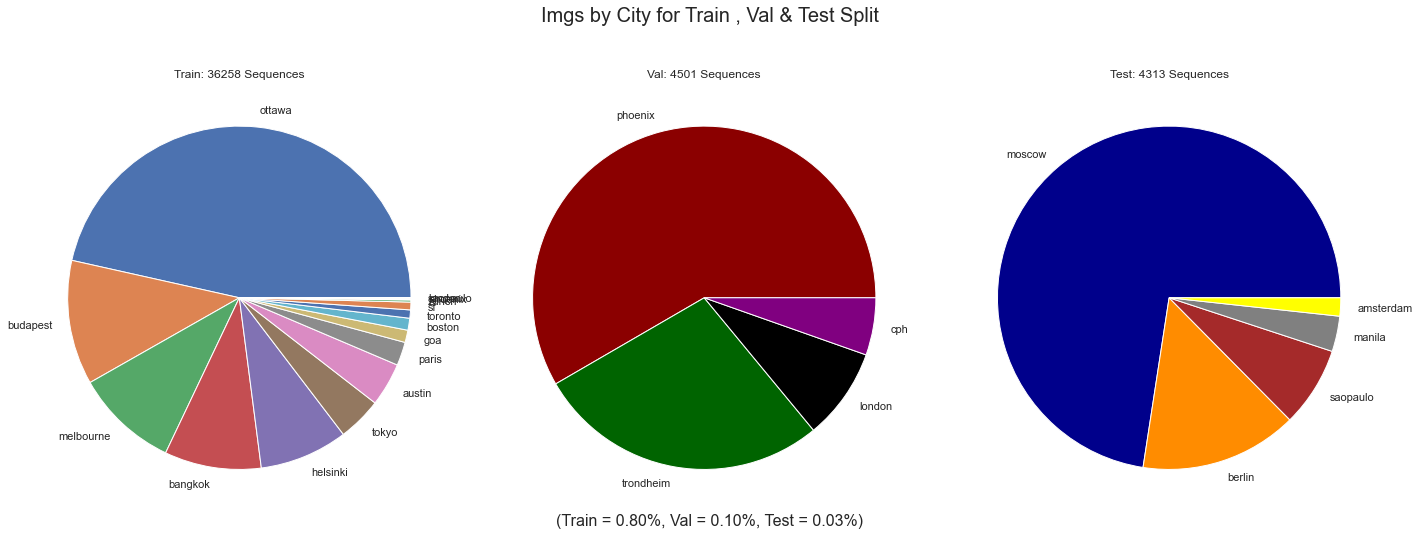

In [9]:
def plot_pie(df,ax,colors = None):

    x = df["City"].value_counts()

    ax.pie(x.values,labels = x.index ,colors = colors)

fig,ax = plt.subplots(1,3,figsize=[20,8])

ax[0].title.set_text(f'Train: {len(train_df)} Sequences')
ax[1].title.set_text(f'Val: {len(val_df)} Sequences')
ax[2].title.set_text(f'Test: {len(test_df)} Sequences')


plot_pie(train_df,ax[0])
plot_pie(val_df,ax[1],colors=["darkred","darkgreen","black","purple"])
plot_pie(test_df,ax[2],colors=["darkblue","darkorange","brown","grey","yellow"])
plt.suptitle(f"Imgs by City for Train , Val & Test Split", fontsize=20)
plt.figtext(0.5, 0.08, f"(Train = {len(train_df)/len(seqs):.2f}%, Val = {len(val_df)/len(seqs):.2f}%, Test = {len(test_df)/len(df):.2f}%)", wrap=True, horizontalalignment='center', fontsize=16)
plt.tight_layout()
#plt.savefig("Imgs/Citys Split.jpg")
plt.show()

Single Images Composition

In [10]:
chosen.head()

,keys,frames,seq_key,cluster_id,view_direction,City_Cluster,Paths,City,ind,ds_type,Flip
index,,,,,,,,,,,
567893,"[3N1XMi3zViT-pJyUdSa2Ow, atxjw6EGIxML6HRVgw2sK...","[206, 207, 208, 209, 210]",wsM-lLblswlROGSKR-f5eQ,632,Forward,0,[Places_Data/train_val/melbourne/database/imag...,melbourne,567893,train,True
567894,"[Kntcesqwsydk_o-sSODzAQ, atxjw6EGIxML6HRVgw2sK...","[208, 209, 210, 211, 212]",wsM-lLblswlROGSKR-f5eQ,632,Forward,0,[Places_Data/train_val/melbourne/database/imag...,melbourne,567894,train,False
567895,"[3N1XMi3zViT-pJyUdSa2Ow, ZC5sEUNKbkccqBOTxFYlM...","[210, 211, 212, 213, 214]",wsM-lLblswlROGSKR-f5eQ,632,Forward,0,[Places_Data/train_val/melbourne/database/imag...,melbourne,567895,train,False
567896,"[6gyfkYpdA7hOfu9awkF1Pg, ncC9Kcnm3hk1pOm-pDvbz...","[212, 213, 214, 215, 216]",wsM-lLblswlROGSKR-f5eQ,632,Forward,0,[Places_Data/train_val/melbourne/database/imag...,melbourne,567896,train,False
567897,"[DlGmWBD86rfZuSGh8MsbxA, 19cPfPu7uuxWrHVqHQqsH...","[214, 215, 216, 217, 218]",wsM-lLblswlROGSKR-f5eQ,632,Forward,0,[Places_Data/train_val/melbourne/database/imag...,melbourne,567897,train,False


In [11]:
len(np.unique(np.concatenate(chosen['keys'].values)))

41032

In [21]:
agg = []
ins = []
for i in tqdm.tqdm(range(len(chosen))):

    row = chosen.iloc[i]
    keys = row['keys']
    paths = row["Paths"]
    for k,p in zip(keys,paths):
        ins.append(k)
        agg.append([p,row['seq_key'],row["cluster_id"],row["view_direction"],row["City"],row["ds_type"]])

chi = pd.DataFrame(agg,index=ins,columns=['path','seq_key','cluster_id','view_direction','city','ds_type'])
chi.index.name = 'key'
chi.drop_duplicates(inplace=True)


100%|██████████| 18158/18158 [00:02<00:00, 6517.58it/s]


In [22]:
chi.value_counts("view_direction")

view_direction
Forward     40426
Backward      606
dtype: int64

In [23]:
# Image_shape = 260
# import tensorflow_datasets as tfds

# def mapping(path,key):
#     global Image_shape

#     image = tf.io.read_file(path)
#     image = tf.io.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [Image_shape,Image_shape])

#     return image, key
# paths = 'D://Felix/Maplliarly Places/' + chi.path.values
# ds = tf.data.Dataset.from_tensor_slices((paths,chi.index.values))
# ds = ds.map(mapping,num_parallel_calls=tf.data.AUTOTUNE)

# for img, path in tqdm.tqdm(tfds.as_numpy(ds)):
    
#     tf.keras.utils.save_img('../../seq_data/train/' + path.decode("utf-8") + ".jpg", img)

In [24]:
new_df = pd.concat([df[(df.view_direction == "Sideways") | (df.ds_type != 'train')].set_index('key'),chi])

In [25]:
f = lambda x: '../seq_data/train/' + x[x.find("images/") + 7 :]
f(new_df.iloc[0,3])
new_df.loc[new_df.local_path.isna(),"local_path"] = new_df.loc[new_df.local_path.isna(),"path"].apply(f)

In [26]:
new_df.value_counts(["view_direction","ds_type"])

view_direction  ds_type
Sideways        train      40838
Forward         train      40426
                test       11031
                val        10645
Sideways        val         5612
                test        5206
Backward        train        606
                val          290
                test           5
dtype: int64

In [27]:
seqs.reset_index().to_feather('new_train_seqs.df')
new_df.reset_index().to_feather('../new_train_imgs.df')